In [1]:
import numpy as np
import pandas as pd
import sklearn
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import math
import random
import matplotlib.pyplot as plt

## 0. Loading DataSet

In [2]:
data_set = np.genfromtxt('Data\magic04.data', delimiter=',', dtype=str) # Data is in the form of array of tuples
labels = data_set[:, len(data_set[0]) - 1:len(data_set[0])]

# 1. Data Balancing

In [3]:
under_sampler = RandomUnderSampler()
sampled_data, sampled_labels = under_sampler.fit_resample(data_set, labels)

In [4]:
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(sampled_labels, return_counts=True)
print(dict(zip(unique, counts)))

{'g': 12332, 'h': 6688}
{'g': 6688, 'h': 6688}


# 2. Data Split


In [5]:
training_data_set, testing_data_set = train_test_split(data_set, test_size=0.3)

In [6]:
training_data = np.array(training_data_set[:, 0:len(training_data_set[0]) - 1]).astype(np.float64)
training_labels = training_data_set[:, len(training_data_set[0]) - 1:len(training_data_set[0])]
training_labels = np.reshape(training_labels, len(training_labels))

In [7]:
testing_data = np.array(testing_data_set[:, 0:len(testing_data_set[0]) - 1]).astype(np.float64)
testing_labels = testing_data_set[:, len(testing_data_set[0]) - 1:len(testing_data_set[0])]
testing_labels = np.reshape(testing_labels, len(testing_labels))

# 3. Classification

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import math
import random

### (a) Decision Tree

In [9]:
def decision_tree(tr_data, tr_labels, tst_data):
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree_pred = decision_tree.fit(tr_data, tr_labels).predict(tst_data)
    return decision_tree_pred

### (b) AdaBoost

In [10]:
def ada_boost(tr_data, tr_labels, tst_data, n_estimators):
    ada_boost = AdaBoostClassifier(n_estimators=n_estimators)
    ada_boost_pred = ada_boost.fit(tr_data, tr_labels).predict(tst_data)
    return ada_boost_pred
    

### (c) K-Nearest Neighbors (K-NN)

In [11]:
def knn(tr_data, tr_labels, tst_data, k_neighb = 3):
    neigh = KNeighborsClassifier(n_neighbors=k_neighb)
    knn_pred = neigh.fit(tr_data, tr_labels).predict(tst_data)
    return knn_pred

### (d) Random Forests


In [12]:
def random_forests(tr_data, tr_labels, tst_data, n_estimators):
    random_forests = RandomForestClassifier(n_estimators=n_estimators)
    random_forests_pred = random_forests.fit(tr_data, tr_labels).predict(tst_data)
    return random_forests_pred
    

### (e) Na¨ıve Bayes


In [13]:
def naive_bayes(tr_data, tr_labels, tst_data):
    gnb = GaussianNB()
    naive_bayes_pred = gnb.fit(tr_data, tr_labels).predict(tst_data)
    return naive_bayes_pred

# 4. Model Parameter Tuning


In [14]:
def splitData(data, labels, n_splits):

  step = math.floor(len(data)/n_splits)

  splitted_data = []
  splitted_labels = []

  index = 0
  for i in range(n_splits):
    if index+step > len(data):
      splitted_data.append(data[index:])
      splitted_labels.append(labels[index:])
    else:
      splitted_data.append(data[index: index+step])
      splitted_labels.append(labels[index:index+step])
    index = index+step

  return splitted_data, splitted_labels


In [15]:
def tuneParamters(splitted_data, splitted_labels, set_classifier_params, domain, kparams):

  params = []

  scores = {}

  # intitialize k random parmaters space
  for i in range(kparams):

    index = random.randint(0, len(domain)-1)
    params.append(domain[index])
    del domain[index]

  # classifing using each generated parameter
  for i in range(kparams):
    
    classifieri = set_classifier_params(params[i])
    sum = 0
    n = len(splitted_data)

    # k-corss validation and compute average score
    for j in range(n):

      #splitting data to train and validation
      training_data = [splitted_data[k] for k in range(n) if k != j]
      training_labels = [splitted_labels[k] for k in range(n) if k != j]
      
      merged_data = []

      for k in range(len(training_data)):
        merged_data.extend(training_data[k])
      training_data = merged_data

      merged_labels = []

      for k in range(len(training_labels)):
        merged_labels.extend(training_labels[k])
      training_labels = merged_labels

      
      testing_data = splitted_data[j]
      testing_labels = splitted_labels[j]

      classifier_pred = classifieri.fit(training_data, training_labels).predict(testing_data)
      accuracy = accuracy_score(testing_labels, classifier_pred)
      sum = sum + accuracy
    scores[params[i]] = sum/n

  return max(scores, key=scores.get)

  



  

In [16]:
splitted_data, splitted_labels = splitData(training_data, training_labels, 2)

#K-nn classifier tuning:
k = tuneParamters(splitted_data, splitted_labels, lambda k: KNeighborsClassifier(n_neighbors=k), [i for i in range(1, 30)], 5)

predictions = knn(training_data, training_labels, testing_data, k)

print(f"Knn accuracy with k = {k} is {accuracy_score(testing_labels, predictions)*100}%")

#adaboost tuning:
n_estimators = tuneParamters(splitted_data, splitted_labels, lambda n_estimators: AdaBoostClassifier(n_estimators=n_estimators), [i for i in range(1, 30)], 5)

predictions = ada_boost(training_data, training_labels, testing_data, n_estimators=n_estimators)

print(f"adaboost accuracy with n_estimators = {n_estimators} is {accuracy_score(testing_labels, predictions)*100}%")

#random forests tuning:
n_estimators = tuneParamters(splitted_data, splitted_labels, lambda n_estimators: RandomForestClassifier(n_estimators=n_estimators), [i for i in range(1, 30)], 5)

predictions = random_forests(training_data, training_labels, testing_data, n_estimators=n_estimators)

print(f"Random forests accuracy with n_estimators = {n_estimators} is {accuracy_score(testing_labels, predictions)*100}%")

Knn accuracy with k = 11 is 80.9323519102699%
adaboost accuracy with n_estimators = 24 is 83.2807570977918%
Random forests accuracy with n_estimators = 21 is 87.90746582544689%


In [17]:
decision_tree_pred = decision_tree(training_data, training_labels, testing_data)
print("Decision tree accuracy: ", accuracy_score(testing_labels, decision_tree_pred) * 100, "%")
precision_score(testing_labels, decision_tree_pred, average='weighted')
recall_score(testing_labels, decision_tree_pred, average='weighted')
f1_score(testing_labels, decision_tree_pred, average='weighted')

Decision tree accuracy:  81.58079214861549 %


0.8156539208040574

In [18]:
naive_bayes_pred = naive_bayes(training_data, training_labels, testing_data)
print("Na¨ıve bayes accuracy: ", accuracy_score(testing_labels, naive_bayes_pred) * 100, "%")
precision_score(testing_labels, naive_bayes_pred, average='weighted')
recall_score(testing_labels, naive_bayes_pred, average='weighted')
f1_score(testing_labels, naive_bayes_pred, average='weighted')

Na¨ıve bayes accuracy:  73.74693305292675 %


0.7123106540467639

In [19]:
k_neighb = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
for k in k_neighb:
    knn_pred = knn(training_data, training_labels, testing_data, k)
    print(str(k) + "-NN accuracy: ", accuracy_score(testing_labels, knn_pred) * 100, "%")
    precision_score(testing_labels, knn_pred, average='weighted')
    recall_score(testing_labels, knn_pred, average='weighted')
    f1_score(testing_labels, knn_pred, average='weighted')

1-NN accuracy:  77.91798107255521 %
2-NN accuracy:  79.07465825446897 %
3-NN accuracy:  80.07360672975815 %
4-NN accuracy:  80.09113214160533 %
5-NN accuracy:  80.54679284963197 %
6-NN accuracy:  80.38906414300736 %
7-NN accuracy:  80.9323519102699 %
8-NN accuracy:  80.9323519102699 %
9-NN accuracy:  80.89730108657554 %
10-NN accuracy:  81.05502979320013 %
11-NN accuracy:  80.9323519102699 %
12-NN accuracy:  80.79214861549247 %
13-NN accuracy:  81.05502979320013 %
14-NN accuracy:  80.91482649842271 %
15-NN accuracy:  81.00245355765861 %
16-NN accuracy:  80.844724851034 %
17-NN accuracy:  81.05502979320013 %
18-NN accuracy:  80.91482649842271 %
19-NN accuracy:  81.16018226428321 %
20-NN accuracy:  81.07255520504731 %


In [20]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
for n in n_estimators:
    ada_boost_pred = ada_boost(training_data, training_labels, testing_data, n)
    print(str(n) + "_estimators AdaBoost accuracy: ", accuracy_score(testing_labels, ada_boost_pred) * 100, "%")
    precision_score(testing_labels, ada_boost_pred, average='weighted')
    recall_score(testing_labels, ada_boost_pred, average='weighted')
    f1_score(testing_labels, ada_boost_pred, average='weighted')

90_estimators AdaBoost accuracy:  85.26112863652295 %
91_estimators AdaBoost accuracy:  85.2260778128286 %
92_estimators AdaBoost accuracy:  85.29617946021732 %
93_estimators AdaBoost accuracy:  85.33123028391168 %
94_estimators AdaBoost accuracy:  85.24360322467578 %
95_estimators AdaBoost accuracy:  85.24360322467578 %
96_estimators AdaBoost accuracy:  85.26112863652295 %
97_estimators AdaBoost accuracy:  85.27865404837014 %
98_estimators AdaBoost accuracy:  85.26112863652295 %
99_estimators AdaBoost accuracy:  85.27865404837014 %
100_estimators AdaBoost accuracy:  85.26112863652295 %


In [21]:
n_estimators = [90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
for n in n_estimators:
    random_forests_pred = random_forests(training_data, training_labels, testing_data, n)
    print(str(n) + "_estimators random forests accuracy: ", accuracy_score(testing_labels, random_forests_pred) * 100, "%")
    precision_score(testing_labels, random_forests_pred, average='weighted')
    recall_score(testing_labels, random_forests_pred, average='weighted')
    f1_score(testing_labels, random_forests_pred, average='weighted')

90_estimators random forests accuracy:  88.5559060637925 %
91_estimators random forests accuracy:  88.53838065194533 %
92_estimators random forests accuracy:  88.10024535576586 %
93_estimators random forests accuracy:  88.24044865054329 %
94_estimators random forests accuracy:  88.5559060637925 %
95_estimators random forests accuracy:  88.18787241500175 %
96_estimators random forests accuracy:  88.64353312302839 %
97_estimators random forests accuracy:  88.74868559411146 %
98_estimators random forests accuracy:  88.59095688748685 %
99_estimators random forests accuracy:  88.50332982825097 %
100_estimators random forests accuracy:  88.45075359270943 %


# 5. Report Requirements

# 6. Bonus

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import preprocessing

In [23]:
EPOCHS = 2000

In [24]:
le = preprocessing.LabelEncoder()
training_encoded_labels = le.fit_transform(training_labels)
testing_encoded_labels = le.fit_transform(testing_labels)

In [25]:
print(f'Training Data Shape {training_data.shape}')
print(f'Training Label Shape {training_encoded_labels.shape}')

Training Data Shape (13314, 10)
Training Label Shape (13314,)


In [26]:
print(f'Training Data  {training_data[0]}')
print(f'Training Label {training_encoded_labels[0]}')

Training Data  [8.27097e+01 3.30359e+01 3.71440e+00 1.63300e-01 8.46000e-02 2.95431e+01
 6.10629e+01 1.90000e+01 1.21600e+00 2.91139e+02]
Training Label 0


In [27]:
X_train_val = torch.from_numpy(training_data).float()
X_test = torch.from_numpy(testing_data).float()
y_train_val = torch.from_numpy(training_encoded_labels).float()
y_test = torch.from_numpy(testing_encoded_labels).float()

In [28]:
print(X_train_val.shape)
print(X_test.shape)

torch.Size([13314, 10])
torch.Size([5706, 10])


In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42) 

In [30]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

torch.Size([11982, 10])
torch.Size([1332, 10])
torch.Size([5706, 10])


In [31]:
class ClassificationModel(nn.Module):
    def __init__(self, input_layer, hidden_layer_1, hidden_layer_2, output_layer):
        super(ClassificationModel, self).__init__()
        self.l1 = nn.Linear(input_layer, hidden_layer_1)
        self.l2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.out = nn.Linear(hidden_layer_2, output_layer)
 
    def forward(self, data):
        x = self.l1(data)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.out(x)
        return torch.sigmoid(x)
     


In [32]:

def train_eval_model(model, epochs, optimizer, loss_fn, X_train, X_val, y_train, y_val, cross_val=False):
    acc_data_val = []
    acc_data_train = []
    loss_data_val = []
    loss_data_train = []

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        model.train()
        y_pred_train = model(X_train)
        loss_train = loss_fn(y_pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        model.eval()
        y_pred_val = model(X_val)
        loss_val = loss_fn(y_pred_val, y_val)
        condition = y_pred_val >= 0.5
        y_pred_val = torch.where(condition, 1, 0)
        val_acc = torch.sum(y_pred_val == y_val) / len(y_val)

        condition = y_pred_train >= 0.5
        y_pred_train = torch.where(condition, 1, 0)
        train_acc = torch.sum(y_pred_train == y_train) / len(y_train)
        if epoch % 250 == 0 and not cross_val:
            print(f'{epoch} : Training loss {loss_train} && Training Acc is {train_acc} || Val loss {loss_val} && Val Acc is {val_acc}')
        acc_data_val.append(val_acc)
        acc_data_train.append(train_acc)
        loss_data_val.append(loss_val.detach().numpy())
        loss_data_train.append(loss_train.detach().numpy())

    return np.array(acc_data_train), np.array(acc_data_val), np.array(loss_data_train), np.array(loss_data_val)
            

In [33]:
model_1 = ClassificationModel(10, 16, 32, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=1e-4)
acc_data_train_1, acc_data_val_1, loss_data_train_1, loss_data_val_1 = train_eval_model(model_1, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 0.8336156606674194 && Training Acc is 0.7001335620880127 || Val loss 0.8687984943389893 && Val Acc is 0.695195198059082
250 : Training loss 0.5321425199508667 && Training Acc is 0.7283425331115723 || Val loss 0.5495922565460205 && Val Acc is 0.7147147059440613
500 : Training loss 0.5089632868766785 && Training Acc is 0.7423635721206665 || Val loss 0.53044593334198 && Val Acc is 0.7237237095832825
750 : Training loss 0.4953991174697876 && Training Acc is 0.7505424618721008 || Val loss 0.5191294550895691 && Val Acc is 0.7312312126159668
1000 : Training loss 0.48213016986846924 && Training Acc is 0.7627274394035339 || Val loss 0.5065453052520752 && Val Acc is 0.7409909963607788
1250 : Training loss 0.4650450646877289 && Training Acc is 0.7808379530906677 || Val loss 0.48884499073028564 && Val Acc is 0.7635135054588318
1500 : Training loss 0.44916021823883057 && Training Acc is 0.7971123456954956 || Val loss 0.47095394134521484 && Val Acc is 0.7755255103111267
1750 : Trai

In [34]:
model_2 = ClassificationModel(10, 64, 128, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-4)
acc_data_train_2, acc_data_val_2, loss_data_train_2, loss_data_val_2 = train_eval_model(model_2, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 7.443737030029297 && Training Acc is 0.3486062288284302 || Val loss 6.734973430633545 && Val Acc is 0.3611111044883728
250 : Training loss 0.48280733823776245 && Training Acc is 0.768903374671936 || Val loss 0.5050297379493713 && Val Acc is 0.7462462186813354
500 : Training loss 0.4532567858695984 && Training Acc is 0.7891837954521179 || Val loss 0.4816310703754425 && Val Acc is 0.7635135054588318
750 : Training loss 0.43175265192985535 && Training Acc is 0.8030378818511963 || Val loss 0.46493345499038696 && Val Acc is 0.7792792916297913
1000 : Training loss 0.4135574996471405 && Training Acc is 0.8143882751464844 || Val loss 0.45140519738197327 && Val Acc is 0.7860360145568848
1250 : Training loss 0.396808922290802 && Training Acc is 0.8231514096260071 || Val loss 0.4395972788333893 && Val Acc is 0.8003003001213074
1500 : Training loss 0.3821979761123657 && Training Acc is 0.8325822353363037 || Val loss 0.43041422963142395 && Val Acc is 0.8063063025474548
1750 : Trai

In [35]:
model_3 = ClassificationModel(10, 128, 512, 1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=1e-4)
acc_data_train_3, acc_data_val_3, loss_data_train_3, loss_data_val_3 = train_eval_model(model_3, 2000, optimizer, loss_fn, X_train, X_val, y_train.reshape(-1, 1), y_val.reshape(-1, 1))

0 : Training loss 3.3785147666931152 && Training Acc is 0.3508596122264862 || Val loss 2.3269126415252686 && Val Acc is 0.3558558523654938
250 : Training loss 0.4440893232822418 && Training Acc is 0.7965281009674072 || Val loss 0.47389551997184753 && Val Acc is 0.7702702879905701
500 : Training loss 0.402678519487381 && Training Acc is 0.8220664262771606 || Val loss 0.4413677155971527 && Val Acc is 0.7905405163764954
750 : Training loss 0.37163713574409485 && Training Acc is 0.8385912179946899 || Val loss 0.4240533411502838 && Val Acc is 0.8063063025474548
1000 : Training loss 0.34947407245635986 && Training Acc is 0.8500250577926636 || Val loss 0.4170480966567993 && Val Acc is 0.8123123049736023
1250 : Training loss 0.33529338240623474 && Training Acc is 0.8543648719787598 || Val loss 0.41808560490608215 && Val Acc is 0.8183183073997498
1500 : Training loss 0.3251115083694458 && Training Acc is 0.8590385317802429 || Val loss 0.4262846112251282 && Val Acc is 0.8168168067932129
1750 : T

In [36]:
def plot_acc_loss(acc_data_train, acc_data_val, loss_data_train, loss_data_val):
    x_axis = range(0, EPOCHS+1)
    fig, axs = plt.subplots(1, 2, figsize=[18, 5])
    
    axs[0].plot(x_axis, acc_data_train, '--', color="r",  label="Training score")
    axs[0].plot(x_axis, acc_data_val, color="b", label="Cross-validation score")
    axs[0].set_title("Accuracy Curve")
    axs[0].set_xlabel("Training Set Size")
    axs[0].set_ylabel("Accuracy Score"), plt.legend(loc="best")
    axs[0].legend()
    
    axs[1].plot(x_axis, loss_data_train, '--', color="r",  label="Training loss")
    axs[1].plot(x_axis, loss_data_val, color="b", label="Cross-validation loss")
    axs[1].set_title("Loss Curve")
    axs[1].set_xlabel("Training Set Size")
    axs[1].set_ylabel("Loss Score"), plt.legend(loc="best")
    axs[1].legend()
    plt.show()

No handles with labels found to put in legend.


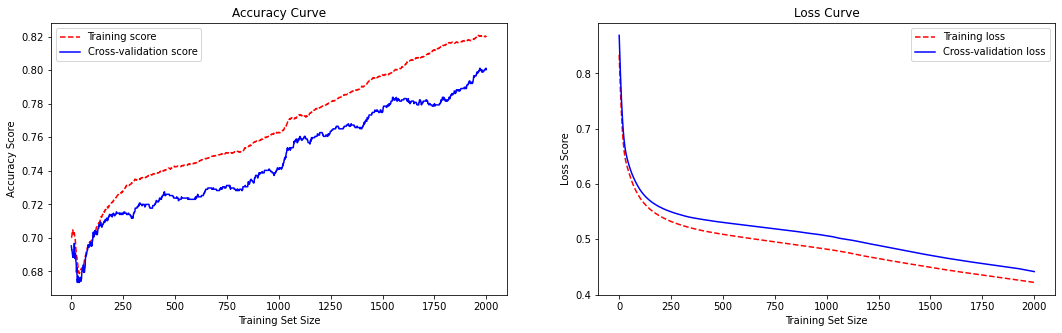

In [37]:
plot_acc_loss(acc_data_train_1, acc_data_val_1, loss_data_train_1, loss_data_val_1)

No handles with labels found to put in legend.


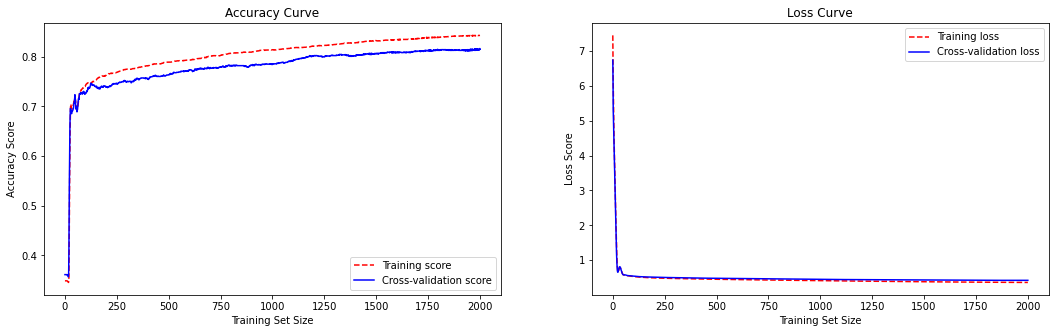

In [38]:
plot_acc_loss(acc_data_train_2, acc_data_val_2, loss_data_train_2, loss_data_val_2)

No handles with labels found to put in legend.


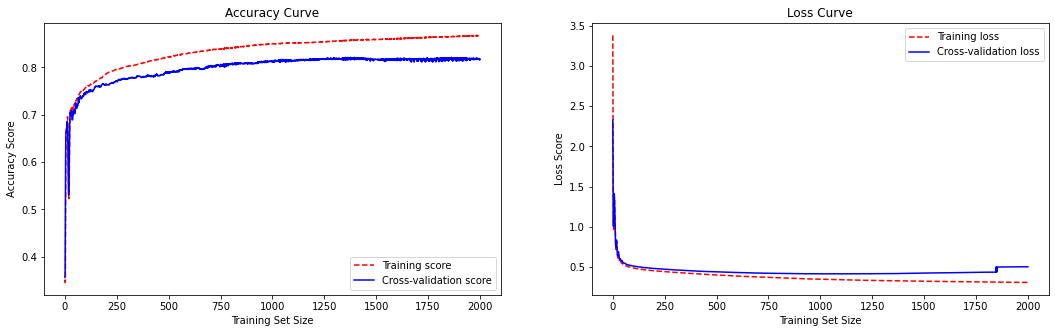

In [39]:
plot_acc_loss(acc_data_train_3, acc_data_val_3, loss_data_train_3, loss_data_val_3)

In [40]:
def evalute_test(model, X_test, y_test):
    model.eval()
    y_pred_test = model(X_test)
    cond = y_pred_test >= 0.5
    y_pred_test = torch.where(cond, 1, 0)
    train_acc = torch.sum(y_pred_test == y_test) / len(y_test)
    print(f"Model Acc. on Test Data {train_acc}")

In [41]:
evalute_test(model_1, X_test, y_test.reshape(-1, 1))
evalute_test(model_2, X_test, y_test.reshape(-1, 1))
evalute_test(model_3, X_test, y_test.reshape(-1, 1))

Model Acc. on Test Data 0.8101997971534729
Model Acc. on Test Data 0.8322818279266357
Model Acc. on Test Data 0.8305292725563049


In [42]:
y_list = torch.chunk(y_train_val, 10)
x_list = torch.chunk(X_train_val, 10)

In [43]:
x_list[0].shape

torch.Size([1332, 10])

In [44]:
def get_val_train(data, ind):
    val = data[ind]
    train = torch.Tensor()
    for i in range(len(data)):
        if i != ind:
            train = torch.cat((train, data[i]), dim=0)

    return train, val

In [45]:
param = [
    [16, 32],
    [32, 64],
    [64, 128],
    [128, 256],
    [256, 512],
]

In [51]:
def kfold(param, x_list, y_list, k, ephocs):
    best_loss_val = float('inf')
    best_acc_val = 0
    best_acc_train = 0
    best_loss_train = 0
    best_model = None
    for p in param:
        model =  ClassificationModel(10, p[0], p[1], 1)
        loss_fn = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
        total_loss_val = 0
        total_loss_train = 0
        total_acc_val = 0
        total_acc_train = 0
        for i in range(k):
            x_t, x_v = get_val_train(x_list, i)
            y_t, y_v = get_val_train(y_list, i)
            acc_data_train, acc_data_val, loss_data_train, loss_data_val = train_eval_model(model, ephocs, optimizer, loss_fn, x_t, x_v, y_t.reshape(-1, 1), y_v.reshape(-1, 1), cross_val=True)
            total_loss_train += np.sum(loss_data_train, axis=0) / ephocs
            total_loss_val += np.sum(loss_data_val, axis=0) / ephocs
            total_acc_train += np.sum(acc_data_train, axis=0) / ephocs
            total_acc_val += np.sum(acc_data_val, axis=0) / ephocs
        print(f'Using {p[0]},{p[1]} Training loss {total_loss_train / k} && Training Acc  {total_acc_val / k} || Val loss {total_loss_val / k} && Val Acc {total_acc_val / k}')
        if best_loss_val > total_loss_val / k:
            best_model = model
            best_loss_val = total_loss_val / k
            best_acc_val = total_acc_val / k
            best_loss_train = total_loss_train / k
            best_acc_train = total_acc_train / k
    return best_model, best_acc_train, best_loss_train, best_acc_val, best_loss_val


In [52]:
bestm, best_acc_train, best_loss_train, best_acc_val, best_loss_val = kfold(param, x_list, y_list, 10, 2000)

Using 16,32 Training loss 0.5890575775146484 && Training Acc  0.7614491638183594 || Val loss 0.5732836181640625 && Val Acc 0.7614491638183594
Using 32,64 Training loss 0.46378628234863284 && Training Acc  0.7984579956054688 || Val loss 0.4706030426025391 && Val Acc 0.7984579956054688
Using 64,128 Training loss 0.4221237121582031 && Training Acc  0.8095386047363281 || Val loss 0.4346036071777344 && Val Acc 0.8095386047363281
Using 128,256 Training loss 0.34709596557617184 && Training Acc  0.8370827453613281 || Val loss 0.3670499572753906 && Val Acc 0.8370827453613281


In [ ]:
print(f'Best Model parameters :  {bestm.parameters}')

Best Model parameters :  <bound method Module.parameters of ClassificationModel(
  (l1): Linear(in_features=10, out_features=16, bias=True)
  (l2): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)>


In [ ]:
evalute_test(bestm, X_test, y_test.reshape(-1, 1))

Model Acc. on Test Data 0.8221170902252197


### Scaling Data